#Class-Balanced Resampling with SMOTE

The process is used to balance class distribution in the dataset (`data`) by oversampling minority classes and undersampling majority classes, ensuring each class contributes proportionally to the final dataset (`resampled_data`) of `total_samples` size, crucial for improving machine learning model performance, especially when classes are imbalanced.

In [ ]:
# Load necessary libraries
import pandas as pd
from sklearn.utils import resample

# Load the dataset from the specified file path
file_path = '/content/ANsWork - Sheet1.csv'
data = pd.read_csv(file_path)

# Assuming the first column is the target variable, extract y (target) and X (features)
y = data.iloc[:, 0]    # Target variable
X = data.iloc[:, 1:]   # Features

# Convert the target variable to categorical if it's numeric (int or float)
if y.dtype == 'float64' or y.dtype == 'int64':
    y = y.astype(int).astype(str)

# Combine the target variable and features into a single DataFrame for resampling
data_combined = pd.concat([y, X], axis=1)

# Define the total number of samples desired after resampling
total_samples = 1200

# Calculate the number of samples needed for each class to achieve the desired balance
class_counts = y.value_counts()  # Count occurrences of each class in y
sampling_strategy = {cls: int((count / len(y)) * total_samples) for cls, count in class_counts.items()}

# Resample each class according to the calculated sampling strategy
resampled_data = []
for cls, n_samples in sampling_strategy.items():
    class_data = data_combined[data_combined.iloc[:, 0] == cls]  # Select data for the current class
    resampled_class_data = resample(class_data, replace=True, n_samples=n_samples, random_state=42)  # Resample with replacement
    resampled_data.append(resampled_class_data)

# Combine all resampled data into a single DataFrame
resampled_data = pd.concat(resampled_data)

# Save the resampled data to a new CSV file
output_file_path = '/content/resampled_dataset.csv'
resampled_data.to_csv(output_file_path, index=False)

output_file_path  # Return the path to the saved CSV file

'/content/resampled_dataset.csv'

#Genrate Graph dataset from Tabular Dataset (CSV)

In [ ]:
import numpy as np
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/resampled_dataset.csv')

# Initialize lists to store the row pairs and their correlation coefficients
f_row = []  # List to store the index of the first row in each pair
t_row = []  # List to store the index of the second row in each pair
cor = []    # List to store the correlation coefficient for each pair

# Compute the correlation coefficients for all pairs of rows
for i in range(len(df)):
    for j in range(i+1, len(df)):
        # Calculate the correlation between row i and row j
        correlation = df.iloc[i].corr(df.iloc[j])

        # Store the row indices and their correlation
        f_row.append(i)
        t_row.append(j)
        cor.append(correlation)

# Create a new DataFrame to store the results
corr_df = pd.DataFrame({'target': f_row, 'source': t_row, 'Correlation': cor})

# Print the resulting DataFrame
print(corr_df)

# Increase the row indices by 1 to make them 1-based instead of 0-based
corr_df['source'] = corr_df['source'] + 1
corr_df['target'] = corr_df['target'] + 1

# Print the updated DataFrame of graph dataset
print(corr_df)

# Save the results to a new CSV file
corr_df.to_csv('/content/edge_relationss.csv', index=False)


        target  source  Correlation
0            0       1     0.734895
1            0       2     0.474287
2            0       3     0.717434
3            0       4     0.643757
4            0       5     0.610440
...        ...     ...          ...
714605    1192    1194     0.995192
714606    1192    1195     1.000000
714607    1193    1194     0.991120
714608    1193    1195     0.995706
714609    1194    1195     0.995192

[714610 rows x 3 columns]
        target  source  Correlation
0            1       2     0.734895
1            1       3     0.474287
2            1       4     0.717434
3            1       5     0.643757
4            1       6     0.610440
...        ...     ...          ...
714605    1193    1195     0.995192
714606    1193    1196     1.000000
714607    1194    1195     0.991120
714608    1194    1196     0.995706
714609    1195    1196     0.995192

[714610 rows x 3 columns]


#Graph Neural Network Model

In [15]:
# Importing the necessary libraries
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
# Load the graph dataset data from a CSV file into a Pandas DataFrame
Graph_data = pd.read_csv('/content/edge_relationss.csv')

# Print the shape of the DataFrame, which shows the number of rows and columns
print("Graph dataset shape:", Graph_data.shape)

Graph dataset shape: (714610, 3)


In [17]:
# Print the graph dataset
print(Graph_data)

        target  source  Correlation
0            1       2     0.734895
1            1       3     0.474287
2            1       4     0.717434
3            1       5     0.643757
4            1       6     0.610440
...        ...     ...          ...
714605    1193    1195     0.995192
714606    1193    1196     1.000000
714607    1194    1195     0.991120
714608    1194    1196     0.995706
714609    1195    1196     0.995192

[714610 rows x 3 columns]


In [18]:
# Define the column names for the Node Feature DataFrame
column_names = ["US_ID"] + [f"term_{idx}" for idx in range(6)] + ["Class_c"] #The line creates a list of column names for a DataFrame, starting with "US_ID" for unique node identifiers, followed by 6 feature columns named "term_0" to "term_5", and ending with "Class_c" for node labels.

# Load the node features data from a CSV file into a Pandas DataFrame
Node_Feature = pd.read_csv('/content/Res_Answork - Sheet1.csv')

# Print the shape of the DataFrame, which shows the number of rows and columns
print("Node feature shape:", Node_Feature.shape)

Node feature shape: (1196, 8)


In [19]:
# Print the count of each unique value in the 'Class_c' column of the Node_Feature DataFrame
print(Node_Feature.Class_c.value_counts())

Class_c
1    313
4    294
3    182
6    147
2     91
8     83
7     59
5     27
Name: count, dtype: int64


In [20]:
# Get a sorted list of unique class values from the 'Class_c' column
class_values = sorted(Node_Feature["Class_c"].unique())

# Create a dictionary mapping class names to integer indices
class_idx = {name: id for id, name in enumerate(class_values)}

# Create a dictionary mapping node IDs to integer indices
Node_Feature_idx = {name: idx for idx, name in enumerate(sorted(Node_Feature["US_ID"].unique()))}

# Update the 'US_ID' column to use integer indices instead of original node IDs
Node_Feature["US_ID"] = Node_Feature["US_ID"].apply(lambda name: Node_Feature_idx[name])

# Update the 'source' column in Graph_data to use integer indices instead of original node IDs
Graph_data["source"] = Graph_data["source"].apply(lambda name: Node_Feature_idx[name])

# Update the 'target' column in Graph_data to use integer indices instead of original node IDs
Graph_data["target"] = Graph_data["target"].apply(lambda name: Node_Feature_idx[name])

# Update the 'Class_c' column to use integer indices instead of original class names
Node_Feature["Class_c"] = Node_Feature["Class_c"].apply(lambda value: class_idx[value])

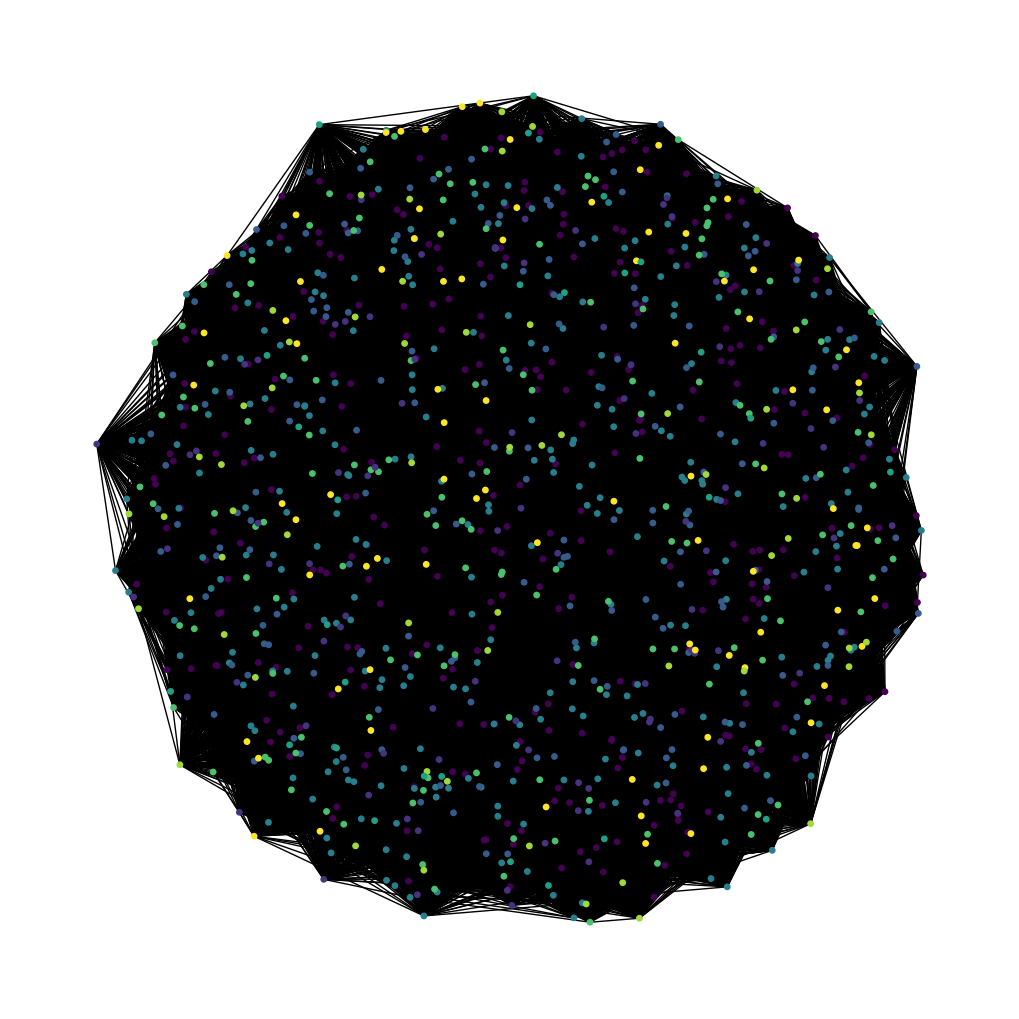

In [21]:
# Set up the figure size for the plot
plt.figure(figsize=(10, 10))

# Get a list of class labels (colors) for each node from the 'Class_c' column
colors = Node_Feature["Class_c"].tolist()

# Create a graph from a sample of the edges in the Graph_data DataFrame
# Sample 102,383 edges to create the graph
cora_graph = nx.from_pandas_edgelist(Graph_data.sample(n=102383))

# Get the class labels (subjects) for the nodes in the graph
subjects = list(Node_Feature[Node_Feature["US_ID"].isin(list(cora_graph.nodes))]["Class_c"])

# Draw the graph using the spring layout
# Each node is colored according to its class label
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

#Baseline model (Feed Forward Neural Network)

In [22]:
# Initialize empty lists to hold the training and test data
train_data, test_data = [], []

# Group the data by the 'Class_c' column and iterate over each group
for _, group_data in Node_Feature.groupby("Class_c"):
    # Randomly select approximately 70% of the data for training
    random_selection = np.random.rand(len(group_data.index)) <= 0.70

    # Append the selected training data to the train_data list
    train_data.append(group_data[random_selection])

    # Append the remaining data to the test_data list
    test_data.append(group_data[~random_selection])

# Concatenate all the training data and shuffle the rows
train_data = pd.concat(train_data).sample(frac=1)

# Concatenate all the test data and shuffle the rows
test_data = pd.concat(test_data).sample(frac=1)

# Print the shape of the training data
print("Train data shape:", train_data.shape)

# Print the shape of the test data
print("Test data shape:", test_data.shape)

Train data shape: (849, 8)
Test data shape: (347, 8)


In [23]:
# Define the number of units (neurons) in each hidden layer of the neural network
hidden_units = [64, 64]

# Set the learning rate for the optimizer, which controls how much to change the model in response to the estimated error each time it passes through the network
learning_rate = 0.01

# Specify the dropout rate, which is the fraction of input units to drop during training to prevent overfitting
dropout_rate = 0.3

# Define the number of epochs, which is the number of times the learning algorithm will work through the entire training dataset
num_epochs = 400

# Set the batch size, which is the number of training examples utilized in one iteration
batch_size = 128

In [24]:
def run_experiment(model, x_train, y_train):
    # Compile the model with specified optimizer, loss function, and metrics
    model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate),  # Optimizer with specified learning rate
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function for sparse categorical targets
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],  # Metric to monitor during training
    )

    # Fit the model to the training data
    history = model.fit(
        x=x_train,  # Input features
        y=y_train,  # Target labels
        epochs=num_epochs,  # Number of training epochs
        batch_size=batch_size,  # Number of samples per gradient update
        validation_split=0.15,  # Fraction of training data to use as validation data
    )

    return history  # Return the training history

In [32]:
def display_learning_curves(history):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss over epochs
    ax1.plot(history.history["loss"])        # Plot training loss
    ax1.plot(history.history["val_loss"])    # Plot validation loss
    ax1.legend(["train", "test"], loc="upper right")  # Add legend indicating train and test curves
    ax1.set_xlabel("Epochs")                 # Label x-axis
    ax1.set_ylabel("Loss")                   # Label y-axis

    # Plot training and validation accuracy over epochs
    ax2.plot(history.history["acc"])         # Plot training accuracy
    ax2.plot(history.history["val_acc"])     # Plot validation accuracy
    ax2.legend(["train", "test"], loc="upper right")  # Add legend indicating train and test curves
    ax2.set_xlabel("Epochs")                 # Label x-axis
    ax2.set_ylabel("Accuracy")               # Label y-axis

    plt.show()  # Display the plot

    fig.savefig("AUC_LOSS.jpg", dpi=600) #save the plot with 600 dpi

In [26]:
def create_ffn(hidden_units, dropout_rate, name=None):
    ffn_layers = []  # Initialize an empty list to store layers

    # Loop over each number of units in hidden_units
    for units in hidden_units:
        # Add BatchNormalization layer to normalize and stabilize the inputs to the next layer
        ffn_layers.append(layers.BatchNormalization())

        # Add Dropout layer to prevent overfitting by randomly setting a fraction of input units to 0 during training
        ffn_layers.append(layers.Dropout(dropout_rate))

        # Add Dense layer (fully connected layer) with specified number of units and activation function
        ffn_layers.append(layers.Dense(units, activation=tf.nn.elu))

    # Create a Sequential model from the list of layers
    return keras.Sequential(ffn_layers, name=name)

In [27]:
feature_names = set(Node_Feature.columns) - {"US_ID", "Class_c"}
'''
1. Node_Feature.columns: Retrieves the column names of the Node_Feature DataFrame.
2. set(Node_Feature.columns): Converts the column names into a set, which contains unique elements (column names).
3. {"US_ID", "Class_c"}: Creates a set with two elements, "US_ID" and "Class_c".
4. set(Node_Feature.columns) - {"US_ID", "Class_c"}: Performs set difference operation, excluding "US_ID" and "Class_c" columns.
5. feature_names: Stores the remaining column names, representing the features of interest.
'''

num_features = len(feature_names) #counts how many columns are considered features.

num_classes = len(class_idx) #counts how many unique classes are present in the dataset, derived from a previously prepared class_idx dictionary.

In [28]:
# Convert the list of feature names to a list (if it isn't already).
feature_names = list(feature_names)

# Create training features as a numpy array from the training data.
x_train = train_data[feature_names].to_numpy()

# Create testing features as a numpy array from the testing data.
x_test = test_data[feature_names].to_numpy()

# Create training targets (labels) as a numpy array from the training data.
y_train = train_data["Class_c"]

# Create testing targets (labels) as a numpy array from the testing data.
y_test = test_data["Class_c"]

In [29]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    # Define input layer for the model with shape based on number of features.
    inputs = layers.Input(shape=(num_features,), name="input_features")

    # Create the first feedforward network block using specified hidden units and dropout rate.
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)

    # Loop to create subsequent feedforward network blocks with skip connections.
    for block_idx in range(4):
        # Create two separate feedforward blocks.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        x2 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 6}")(x)

        # Add skip connections: add the original input (x) to each feedforward block output.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
        x = layers.Add(name=f"skip_connection{block_idx + 6}")([x, x2])

    # Final dense layer to compute logits (output scores) for each class.
    logits = layers.Dense(num_classes, name="logits")(x)

    # Create the Keras model with defined inputs and computed logits as outputs.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

# Create the baseline model with specified parameters.
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)

# Print a summary of the model architecture, detailing the layers, output shapes, and number of parameters.
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 6)]                  0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 64)                   4888      ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 64)                   8832      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 64)                   0         ['ffn_block1[0][0]',   

In [30]:
# Run an experiment using a baseline model with the node feature dataframe's training instances
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/400
6/6 [==============================] - 25s 135ms/step - loss: 4.2198 - acc: 0.2108 - val_loss: 1.9664 - val_acc: 0.3828
Epoch 2/400
6/6 [==============================] - 0s 29ms/step - loss: 2.5782 - acc: 0.3093 - val_loss: 1.7343 - val_acc: 0.3984
Epoch 3/400
6/6 [==============================] - 0s 32ms/step - loss: 2.2794 - acc: 0.3398 - val_loss: 2.3267 - val_acc: 0.1875
Epoch 4/400
6/6 [==============================] - 0s 28ms/step - loss: 2.1620 - acc: 0.3315 - val_loss: 2.0148 - val_acc: 0.2578
Epoch 5/400
6/6 [==============================] - 0s 28ms/step - loss: 2.0607 - acc: 0.3412 - val_loss: 1.6749 - val_acc: 0.3516
Epoch 6/400
6/6 [==============================] - 0s 27ms/step - loss: 1.8608 - acc: 0.3634 - val_loss: 1.5216 - val_acc: 0.4766
Epoch 7/400
6/6 [==============================] - 0s 28ms/step - loss: 1.9306 - acc: 0.3467 - val_loss: 1.7571 - val_acc: 0.3047
Epoch 8/400
6/6 [==============================] - 0s 33ms/step - loss: 1.7467 - acc: 0.

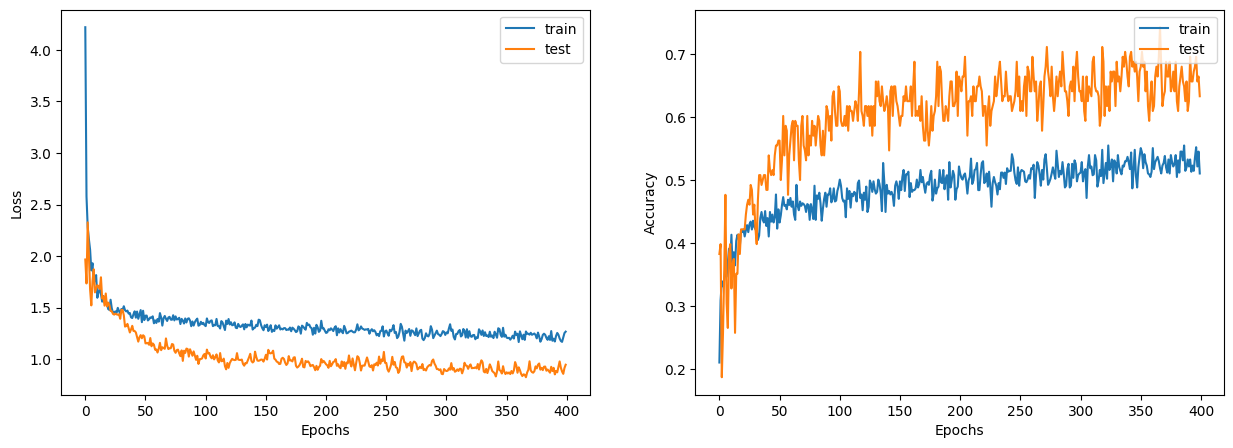

In [33]:
display_learning_curves(history)

In [34]:
# Evaluate the baseline_model on the test instances of the node feature dataset and retrieve the test accuracy.
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
# Print the test accuracy rounded to two decimal places.
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 57.93%


In [35]:
def generate_random_instances(num_instances):
    # Calculate the probability of each token appearing in the training data
    token_probability = x_train.mean(axis=0)

    # Generate random instances based on token probabilities
    instances = []
    for _ in range(num_instances):
        # Generate random probabilities for each token
        probabilities = np.random.uniform(size=len(token_probability))
        # Create an instance where tokens are set based on their probabilities
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    # Display probabilities for each instance and class
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        # Display probabilities for each class
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [36]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 448ms/step
Instance 1:
- 1: 48.57%
- 2: 8.74%
- 3: 5.29%
- 4: 1.7%
- 5: 2.08%
- 6: 29.45%
- 7: 1.3%
- 8: 2.87%
Instance 2:
- 1: 48.57%
- 2: 8.74%
- 3: 5.29%
- 4: 1.7%
- 5: 2.08%
- 6: 29.45%
- 7: 1.3%
- 8: 2.87%
Instance 3:
- 1: 48.57%
- 2: 8.74%
- 3: 5.29%
- 4: 1.7%
- 5: 2.08%
- 6: 29.45%
- 7: 1.3%
- 8: 2.87%
Instance 4:
- 1: 48.57%
- 2: 8.74%
- 3: 5.29%
- 4: 1.7%
- 5: 2.08%
- 6: 29.45%
- 7: 1.3%
- 8: 2.87%
Instance 5:
- 1: 4.39%
- 2: 0.13%
- 3: 0.76%
- 4: 21.66%
- 5: 0.01%
- 6: 11.09%
- 7: 59.02%
- 8: 2.92%
Instance 6:
- 1: 48.57%
- 2: 8.74%
- 3: 5.29%
- 4: 1.7%
- 5: 2.08%
- 6: 29.45%
- 7: 1.3%
- 8: 2.87%
Instance 7:
- 1: 48.57%
- 2: 8.74%
- 3: 5.29%
- 4: 1.7%
- 5: 2.08%
- 6: 29.45%
- 7: 1.3%
- 8: 2.87%
Instance 8:
- 1: 48.57%
- 2: 8.74%
- 3: 5.29%
- 4: 1.7%
- 5: 2.08%
- 6: 29.45%
- 7: 1.3%
- 8: 2.87%


#Graph Data Classification with the GNN Model

In [37]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = Graph_data[["source", "target"]].to_numpy().T

# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])

# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    Node_Feature.sort_values("US_ID")[feature_names].to_numpy(),
    dtype=tf.dtypes.float32
)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

# Print shapes for verification.
print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 714610)
Nodes shape: (1196, 6)


In [38]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.3,
        aggregation_type="mean",
        combination_type="ConvLSTM1D",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Initialize layer parameters
        self.aggregation_type = aggregation_type  # Type of aggregation (sum, mean, max)
        self.combination_type = combination_type  # Type of combination (gated, ConvLSTM1D, concat, add)
        self.normalize = normalize  # Whether to normalize node embeddings

        # Create feedforward network for message preparation
        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)

        # Define update function based on combination type
        if self.combination_type == "gated":
            # GRU for gated combination
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="relu",
                recurrent_activation="elu",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            # Feedforward network for other combination types
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # Prepare messages from node representations
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            # Apply weights if provided
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # Aggregate neighbour messages based on aggregation type
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            # Sum neighbour messages per node
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            # Average neighbour messages per node
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            # Maximum neighbour messages per node
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            # Handle invalid aggregation type
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # Update node representations based on combination type
        if self.combination_type == "ConvLSTM1D":
            # Stack node and aggregated messages for ConvLSTM1D
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate node and aggregated messages
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node and aggregated messages
            h = node_repesentations + aggregated_messages
        else:
            # Handle invalid combination type
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply update function (GRU or feedforward network)
        node_embeddings = self.update_fn(h)

        # For ConvLSTM1D, extract final output
        if self.combination_type == "ConvLSTM1D":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        # Normalize node embeddings
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process inputs to produce node embeddings."""
        node_repesentations, edges, edge_weights = inputs

        # Get source (node_indices) and target (neighbour_indices) from edges
        node_indices, neighbour_indices = edges[0], edges[1]

        # Gather neighbour representations
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare neighbour messages
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)

        # Aggregate neighbour messages
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )

        # Update node representations with aggregated messages
        return self.update(node_repesentations, aggregated_messages)

In [39]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.3,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info into node_features, edges, and edge_weights.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features  # Node features of the graph
        self.edges = edges  # Edges connecting nodes
        self.edge_weights = edge_weights  # Weights associated with each edge

        # Set edge_weights to 1.0 if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a preprocessing layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")

        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )

        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )

        # Create a postprocessing layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")

        # Create a layer to compute logits for classification.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess node_features to produce initial node representations.
        x = self.preprocess(self.node_features)

        # Apply the first graph convolutional layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))

        # Skip connection: add the output of the first layer to the input features.
        x = x1 + x

        # Apply the second graph convolutional layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))

        # Skip connection: add the output of the second layer to the previous output.
        x = x2 + x

        # Postprocess node embeddings.
        x = self.postprocess(x)

        # Fetch node embeddings for the specified input node indices.
        node_embeddings = tf.gather(x, input_node_indices)

        # Compute logits for classification.
        return self.compute_logits(node_embeddings)

This code snippet defines a Graph Neural Network (GNN) model for node classification. It initializes the model with parameters such as graph information (graph_info), number of output classes (num_classes), hidden layer units (hidden_units), dropout rate (dropout_rate), and assigns a name to the model ("gnn_model").

In [40]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100])) #prints the output shape of the GNN model when given input data of sizes [1, 10, 100]. This shows how the model processes input data and produces an output shape.

gnn_model.summary() #This line prints a summary of the GNN model, showing its architecture including the types and shapes of its layers, the number of parameters, and how the data flows through the model.

GNN output shape: tf.Tensor(
[[ 0.02234409  0.32525     0.13556682 -0.16205709 -0.38821936  0.0970222
  -0.2296652   0.14256671]
 [-0.0264589   0.24492991  0.1652877   0.3520807  -0.22509778  0.39926982
   0.25216022 -0.0231567 ]
 [-0.1455959  -0.1896675   0.02418885  0.1576142   0.1945878  -0.06087385
   0.34520555 -0.21532759]], shape=(3, 8), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (1196, 64)                4888      
                                                                 
 graph_conv1 (GraphConvLaye  multiple                  22016     
 r)                                                              
                                                                 
 graph_conv2 (GraphConvLaye  multiple                  22016     
 r)                                                              
                         

In [41]:
x_train = train_data.US_ID.to_numpy()  # Extracting the 'US_ID' column from 'train_data' and converting it to a NumPy array.

history = run_experiment(gnn_model, x_train, y_train)  # Running an experiment using 'gnn_model', 'x_train', and 'y_train', storing results in 'history'.

Epoch 1/400
6/6 [==============================] - 16s 408ms/step - loss: 2.2310 - acc: 0.1969 - val_loss: 1.7046 - val_acc: 0.4062
Epoch 2/400
6/6 [==============================] - 1s 233ms/step - loss: 1.7323 - acc: 0.3897 - val_loss: 1.6550 - val_acc: 0.4844
Epoch 3/400
6/6 [==============================] - 1s 228ms/step - loss: 1.4621 - acc: 0.4411 - val_loss: 1.7710 - val_acc: 0.3438
Epoch 4/400
6/6 [==============================] - 1s 233ms/step - loss: 1.1685 - acc: 0.5270 - val_loss: 2.8934 - val_acc: 0.1875
Epoch 5/400
6/6 [==============================] - 1s 233ms/step - loss: 1.0516 - acc: 0.5603 - val_loss: 2.2355 - val_acc: 0.1953
Epoch 6/400
6/6 [==============================] - 1s 233ms/step - loss: 0.9204 - acc: 0.6144 - val_loss: 2.1995 - val_acc: 0.2031
Epoch 7/400
6/6 [==============================] - 1s 250ms/step - loss: 0.7999 - acc: 0.6852 - val_loss: 3.1623 - val_acc: 0.1797
Epoch 8/400
6/6 [==============================] - 1s 246ms/step - loss: 0.6316 - 

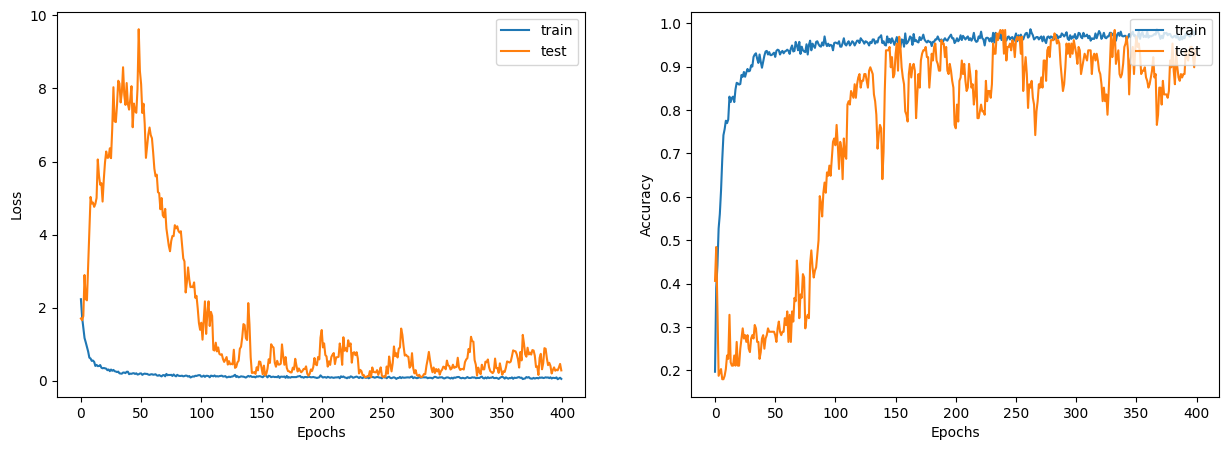

In [42]:
display_learning_curves(history)

In [43]:
# Extracting the unique node IDs from the test_data and converting them to a NumPy array.
x_test = test_data.US_ID.to_numpy()

# Evaluating the trained GNN model on the test dataset,
# calculating the accuracy without verbosity (verbose=0).
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)

# Printing the test accuracy as a percentage rounded to two decimal places.
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 92.8%


In [44]:
import numpy as np

# Using the trained GNN model (gnn_model) to predict probabilities for each class
# on the test input data (x_test).
y_pred_prob = gnn_model.predict(x_test)

# Extracting the predicted class labels by choosing the highest probability index
# along axis 1 (columns) from the predicted probabilities.
y_pred = np.argmax(y_pred_prob, axis=1)

11/11 [==============================] - 1s 50ms/step


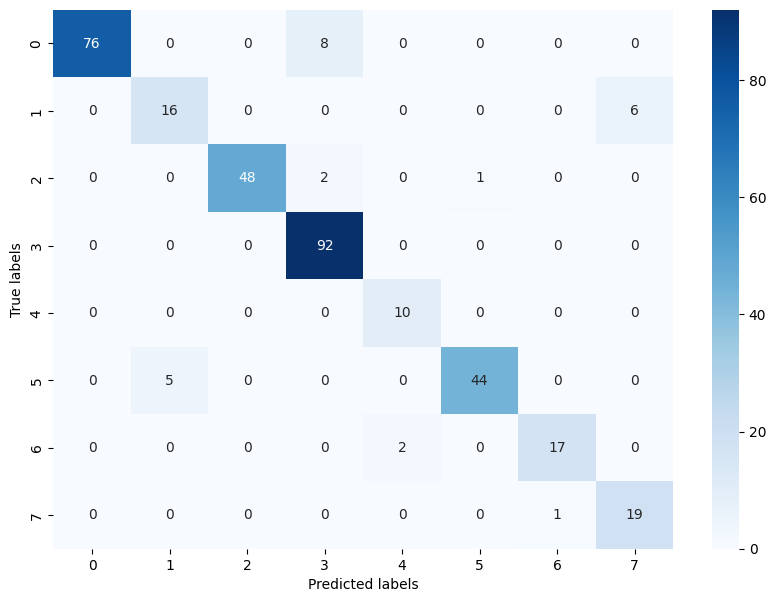

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating the confusion matrix using true labels (y_true) and predicted labels (y_pred).
cm = confusion_matrix(y_test, y_pred)

# Creating a heatmap of the confusion matrix using seaborn, with annotations and a blue color map.
plt.figure(figsize=(10, 7))  # Optional: Set the figure size
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Labeling the x-axis and y-axis of the heatmap.
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

# Saving the figure with a specified filename and DPI before displaying it.
plt.savefig("confusion_matrix.png", dpi=600)

# Displaying the heatmap.
plt.show()
